# <center> <b> 实验五 卷积神经网络基础实验 </b> </center>  
本实验通过MNIST手写数字分类识别案例来说明卷积神经网络的基本架构和分析方法

## 实验目的
1. 了解卷积神经网络的工作原理
2. 掌握利用tensorflow构建神经网络的方法
3. 学习掌握numpy,tensorflow等库的使用

## 实验工具
1. Anaconda, Jupyter Notebook
2. numpy, pandas,sklearn, matplotlib
3. tensorflow

## 实验内容

**1. 加载库**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
from tensorflow.python.framework import ops
ops.reset_default_graph()

ModuleNotFoundError: No module named 'tensorflow'

**启动TensorFlow会话运行环境**

In [2]:
sess = tf.Session()

**2. 加载MNIST手写数字数据集**

In [3]:
data_dir = 'Datasets'
mnist = read_data_sets(data_dir)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting Datasets\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting Datasets\train-labels-idx1-ubyte.gz
Extracting Datasets\t10k-images-idx3-ubyte.gz
Extracting Datasets\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


**转换数据表示**

In [4]:
# 图片转换成28*28格式
train_xdata = np.array([np.reshape(x, (28,28)) for x in mnist.train.images])
test_xdata = np.array([np.reshape(x, (28,28)) for x in mnist.test.images])

# 标签转换成独热码格式
train_labels = mnist.train.labels
test_labels = mnist.test.labels

**3. 设置模型参数**

In [5]:
batch_size = 100
learning_rate = 0.005
evaluation_size = 500
image_width = train_xdata[0].shape[0]
image_height = train_xdata[0].shape[1]
target_size = max(train_labels) + 1
num_channels = 1 #灰度图片
generations = 500
eval_every = 5
conv1_features = 25
conv2_features = 50
max_pool_size1 = 2 # 第一层最大池化采用2*2
max_pool_size2 = 2 # 第一层最大池化采用2*2
fully_connected_size1 = 100

**3. 定义模型的输入输出**

In [6]:
x_input_shape = (batch_size, image_width, image_height, num_channels)
x_input = tf.placeholder(tf.float32, shape=x_input_shape)
y_target = tf.placeholder(tf.int32, shape=(batch_size))

eval_input_shape = (evaluation_size, image_width, image_height, num_channels)
eval_input = tf.placeholder(tf.float32, shape=eval_input_shape)
eval_target = tf.placeholder(tf.int32, shape=(evaluation_size))

**4. 定义卷积神经网络结构**
1. 两个卷积层(4*4)
2. 两个池化层(2*2)
3. 全连接层(1个隐含层) 

定义网络模型相关的**参数**

In [7]:
# 卷积层的权重和偏移
conv1_weight = tf.Variable(tf.truncated_normal([4, 4, num_channels, conv1_features], stddev=0.1, dtype=tf.float32))
conv1_bias = tf.Variable(tf.zeros([conv1_features], dtype=tf.float32))

conv2_weight = tf.Variable(tf.truncated_normal([4, 4, conv1_features, conv2_features], stddev=0.1, dtype=tf.float32))
conv2_bias = tf.Variable(tf.zeros([conv2_features], dtype=tf.float32))

# 全连接层输入参数
resulting_width = image_width // (max_pool_size1 * max_pool_size2)
resulting_height = image_height // (max_pool_size1 * max_pool_size2)
full1_input_size = resulting_width * resulting_height * conv2_features

#全连接层
full1_weight = tf.Variable(tf.truncated_normal([full1_input_size, fully_connected_size1], stddev=0.1, dtype=tf.float32))
full1_bias = tf.Variable(tf.truncated_normal([fully_connected_size1], stddev=0.1, dtype=tf.float32))
full2_weight = tf.Variable(tf.truncated_normal([fully_connected_size1, target_size], stddev=0.1, dtype=tf.float32))
full2_bias = tf.Variable(tf.truncated_normal([target_size], stddev=0.1, dtype=tf.float32))

**定义卷积神经网络结构**  
(卷积1)-->(激活1)-->(最大池化1)-->(卷积2)-->(激活2)-->(最大池化2)-->(全连接层1)-->(全连接层2)-->预测输出

In [8]:
def Lab5_conv_net(input_data):
    # 第一Conv-ReLU-MaxPool层
    conv1 = tf.nn.conv2d(input_data, conv1_weight, strides=[1, 1, 1, 1], padding='SAME')
    relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_bias))
    max_pool1 = tf.nn.max_pool(relu1, ksize=[1, max_pool_size1, max_pool_size1, 1],
                               strides=[1, max_pool_size1, max_pool_size1, 1], padding='SAME')

    # 第二Conv-ReLU-MaxPool层
    conv2 = tf.nn.conv2d(max_pool1, conv2_weight, strides=[1, 1, 1, 1], padding='SAME')
    relu2 = tf.nn.relu(tf.nn.bias_add(conv2, conv2_bias))
    max_pool2 = tf.nn.max_pool(relu2, ksize=[1, max_pool_size2, max_pool_size2, 1],
                               strides=[1, max_pool_size2, max_pool_size2, 1], padding='SAME')

    # 连接到全连接输入层
    final_conv_shape = max_pool2.get_shape().as_list()
    final_shape = final_conv_shape[1] * final_conv_shape[2] * final_conv_shape[3]
    flat_output = tf.reshape(max_pool2, [final_conv_shape[0], final_shape])

    # 第一全连接层
    fully_connected1 = tf.nn.relu(tf.add(tf.matmul(flat_output, full1_weight), full1_bias))

    # 第二全连接层
    final_model_output = tf.add(tf.matmul(fully_connected1, full2_weight), full2_bias)
    
    return(final_model_output)

model_output = Lab5_conv_net(x_input)
test_model_output = Lab5_conv_net(eval_input)

采用softmax交叉熵损失函数

In [9]:
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model_output, labels=y_target))

定于预测节点和测试节点函数

In [10]:
# 定于预测节点和测试节点
prediction = tf.nn.softmax(model_output)
test_prediction = tf.nn.softmax(test_model_output)

# 定义精度评价函数
def get_accuracy(logits, targets):
    batch_predictions = np.argmax(logits, axis=1)
    num_correct = np.sum(np.equal(batch_predictions, targets))
    return(100. * num_correct/batch_predictions.shape[0])

采用Momentum优化器，学习率为0.005，学习率衰减为0.9

In [11]:
my_optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9)
train_step = my_optimizer.minimize(loss)

# 初始化
init = tf.global_variables_initializer()
sess.run(init)

**5. 启动训练**

In [12]:
train_loss = []
train_acc = []
test_acc = []
for i in range(generations):
    rand_index = np.random.choice(len(train_xdata), size=batch_size)
    rand_x = train_xdata[rand_index]
    rand_x = np.expand_dims(rand_x, 3)
    rand_y = train_labels[rand_index]
    train_dict = {x_input: rand_x, y_target: rand_y}
    
    sess.run(train_step, feed_dict=train_dict)
    temp_train_loss, temp_train_preds = sess.run([loss, prediction], feed_dict=train_dict)
    temp_train_acc = get_accuracy(temp_train_preds, rand_y)
    
    if (i+1) % eval_every == 0:
        eval_index = np.random.choice(len(test_xdata), size=evaluation_size)
        eval_x = test_xdata[eval_index]
        eval_x = np.expand_dims(eval_x, 3)
        eval_y = test_labels[eval_index]
        test_dict = {eval_input: eval_x, eval_target: eval_y}
        test_preds = sess.run(test_prediction, feed_dict=test_dict)
        temp_test_acc = get_accuracy(test_preds, eval_y)
        
        # Record and print results
        train_loss.append(temp_train_loss)
        train_acc.append(temp_train_acc)
        test_acc.append(temp_test_acc)
        acc_and_loss = [(i+1), temp_train_loss, temp_train_acc, temp_test_acc]
        acc_and_loss = [np.round(x,2) for x in acc_and_loss]
        print('Generation # {}. Train Loss: {:.2f}. Train Acc (Test Acc): {:.2f} ({:.2f})'.format(*acc_and_loss))

Generation # 5. Train Loss: 2.28. Train Acc (Test Acc): 19.00 (17.00)
Generation # 10. Train Loss: 2.20. Train Acc (Test Acc): 22.00 (26.40)
Generation # 15. Train Loss: 2.12. Train Acc (Test Acc): 30.00 (34.40)
Generation # 20. Train Loss: 1.90. Train Acc (Test Acc): 42.00 (46.20)
Generation # 25. Train Loss: 1.76. Train Acc (Test Acc): 48.00 (51.60)
Generation # 30. Train Loss: 1.42. Train Acc (Test Acc): 74.00 (69.40)
Generation # 35. Train Loss: 1.16. Train Acc (Test Acc): 71.00 (68.60)
Generation # 40. Train Loss: 0.93. Train Acc (Test Acc): 75.00 (75.20)
Generation # 45. Train Loss: 0.84. Train Acc (Test Acc): 78.00 (78.60)
Generation # 50. Train Loss: 0.70. Train Acc (Test Acc): 83.00 (84.80)
Generation # 55. Train Loss: 0.47. Train Acc (Test Acc): 86.00 (83.20)
Generation # 60. Train Loss: 0.52. Train Acc (Test Acc): 84.00 (87.20)
Generation # 65. Train Loss: 0.31. Train Acc (Test Acc): 92.00 (85.60)
Generation # 70. Train Loss: 0.37. Train Acc (Test Acc): 91.00 (86.00)
Generat

**绘制损失和精度曲线图**

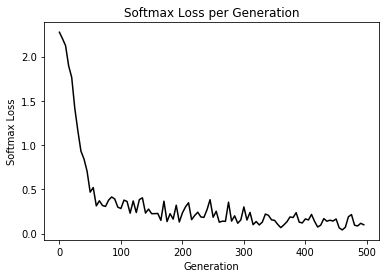

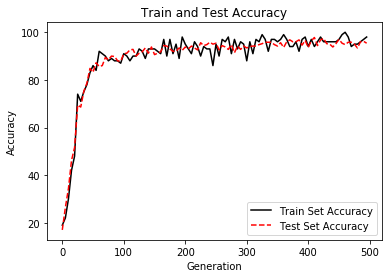

In [13]:
eval_indices = range(0, generations, eval_every)
# 损失曲线图
plt.plot(eval_indices, train_loss, 'k-')
plt.title('Softmax Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Softmax Loss')
plt.show()

# 训练和测试精度图
plt.plot(eval_indices, train_acc, 'k-', label='Train Set Accuracy')
plt.plot(eval_indices, test_acc, 'r--', label='Test Set Accuracy')
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

**6. 模型测试**

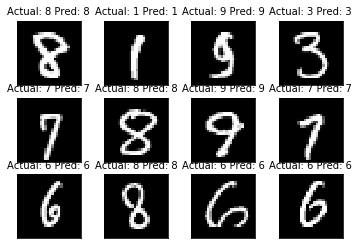

In [14]:
actuals = rand_y[0:12]
predictions = np.argmax(temp_train_preds,axis=1)[0:12]
images = np.squeeze(rand_x[0:12])

Nrows = 3
Ncols = 4
for i in range(12):
    plt.subplot(Nrows, Ncols, i+1)
    plt.imshow(np.reshape(images[i], [28,28]), cmap='Greys_r')
    plt.title('Actual: ' + str(actuals[i]) + ' Pred: ' + str(predictions[i]),
                               fontsize=10)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
plt.show()

**7. 实验作业**  
(1) 绘制本实验卷积神经网络结构示意图  
(2) 用自己手写的数字图片进行测试